<a href="https://colab.research.google.com/github/matheus-de-araujo/fakenews-classifier-notebook/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importação das bibliotecas

In [77]:
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import hashlib
import string
import os, re

# Nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import RSLPStemmer
import nltk

# Sklearn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle


# 2. Realizando a leitura do dataset

In [78]:
if os.path.exists('dataset-fake-br-for-tcc/'):
    print('A pasta já existe!')
else:
  !git clone https://github.com/matheus-de-araujo/dataset-fake-br-for-tcc.git

def returnDataSetFrame():
    dataFrame = pd.DataFrame(columns=[ 'text', 'raw', 'label'])
    paths = ['dataset-fake-br-for-tcc/full_texts/fake/', 'dataset-fake-br-for-tcc/full_texts/true/']

    for filename in os.listdir(paths[0]):
        with open(paths[0]+filename, 'r') as f:
            text = f.read()
            dataFrame.loc[len(dataFrame)] = [preProcessing(text, forCloudOfWords = False), text, 'fake']

    for filename in os.listdir(paths[1]):
        with open(paths[1]+filename, 'r') as f:
            text = f.read()
            dataFrame.loc[len(dataFrame)] = [preProcessing(text, forCloudOfWords = False), text, 'true']
    return dataFrame

A pasta já existe!


# 3. Funções para limpeza dos dados e remoção dos StopWords

In [79]:
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')

def cleaning_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub("(\\d|\\W|\d+\w+|\\n)+"," ",sentence)
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    return sentence

def removeStopWords(sentence):
    stopwords_nltk = nltk.corpus.stopwords.words('portuguese')
    sentence = ' '.join([word for word in sentence.split() if word not in stopwords_nltk])
    return sentence

def preProcessing(sentence, forCloudOfWords = True):
    if (forCloudOfWords):
        return removeStopWords(cleaning_sentence(sentence))
    return removeStopWords(cleaning_sentence(sentence))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 4. Obténdo o dataset e guardando em data

In [80]:
data_text = returnDataSetFrame()
data_text.head()

,text,raw,label
0,morre médico caiu varanda tirar selfie pousada...,Morre médico que caiu de varanda ao tirar self...,fake
1,entrevista pt tentou censurar carlos vereza so...,A entrevista que o PT tentou censurar. Carlos ...,fake
2,eua coreia sul disparam fogo real usando bobar...,EUA e Coreia do Sul disparam fogo real usando ...,fake
3,wikileaks diz temer espião eua wikileaks porta...,Wikileaks diz que Temer era espião dos EUA. . ...,fake
4,polícia vaticano flagra orgia gay apartamento ...,"Polícia do Vaticano flagra ""orgia gay"" em apar...",fake


# 5. Funções para plotar nuvem de palavras

In [81]:
def bagOfWords(text):
    words = text.split()
    counter = Counter(words) 
    return counter.most_common()
    
def cloudOfWords(text, n = 50,title='Bag of Words'):
    word_freq = dict((x, y) for x, y in bagOfWords(text)[:n])
    wordcloud = WordCloud(background_color='white', width=1600, height=800)
    wordcloud.generate_from_frequencies(word_freq)
    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

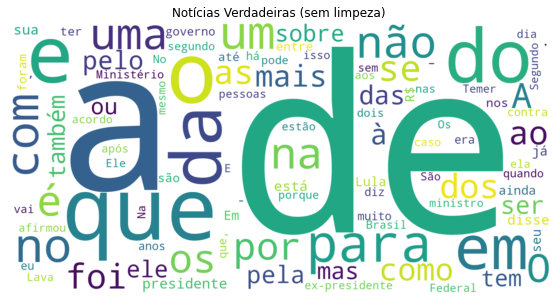

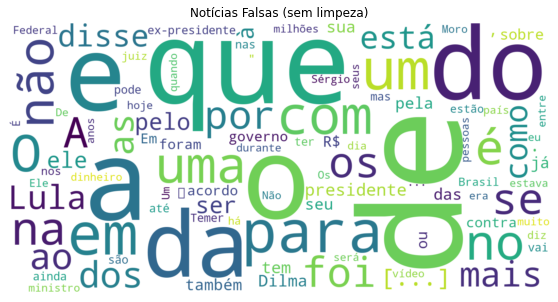

In [82]:
data_raw_true = ' '.join(data_text[data_text.label == 'true']['raw'])
data_raw_fake = ' '.join(data_text[data_text.label == 'fake']['raw'])

cloudOfWords(text=data_raw_true, title='Notícias Verdadeiras (sem limpeza)', n=100)
cloudOfWords(text=data_raw_fake, title='Notícias Falsas (sem limpeza)', n=100)

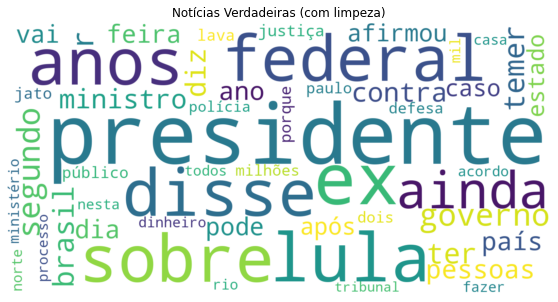

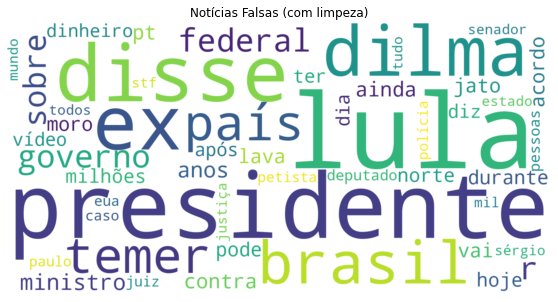

In [83]:
cloudOfWords(text=preProcessing(data_raw_true), title='Notícias Verdadeiras (com limpeza)')
cloudOfWords(text=preProcessing(data_raw_fake), title='Notícias Falsas (com limpeza)')

## 7. Plotando o gráfico que demonstra número de ocorrência

Número total de palavras: 2614766


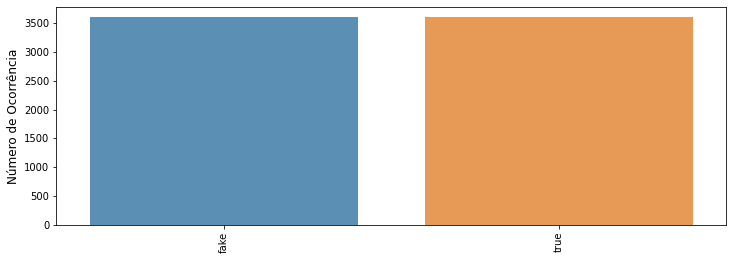

In [84]:
print("Número total de palavras: " + str(data_text['text'].apply(lambda x: len(x.split(' '))).sum()))

label_plot = data_text['label'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(y=label_plot.values, x=label_plot.index, alpha=0.8)
plt.ylabel('Número de Ocorrência', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [85]:
vectorizer = TfidfVectorizer(max_df=0.85)

data = data_text.sample(frac=1)
text = data['text']
label = data['label'].rank(method='dense', ascending=False).astype(int)

data_train = vectorizer.fit_transform(text)

x_train, x_test, y_train, y_test = train_test_split(text, label, test_size=0.33, random_state=42)

x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.fit_transform(x_test)

In [86]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

---- Scores ----
[0.95652174 0.94202899 0.97308489 0.95031056 0.9626556  0.97095436
 0.95850622 0.95643154 0.95643154 0.96680498]
              precision    recall  f1-score   support

           1       0.94      0.95      0.95      1177
           2       0.95      0.94      0.95      1199

    accuracy                           0.95      2376
   macro avg       0.95      0.95      0.95      2376
weighted avg       0.95      0.95      0.95      2376



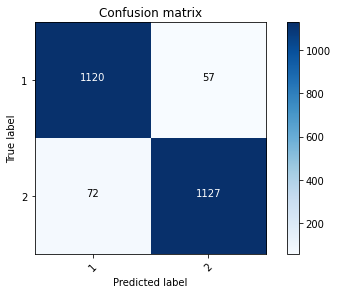

In [87]:
neural_classifier = MLPClassifier(hidden_layer_sizes=(5,12),activation='tanh',solver='lbfgs',random_state=1)
scores_neural = cross_val_score(neural_classifier, x_train, y_train, cv=10)
Y_pred = cross_val_predict(neural_classifier,x_test,y_test, cv=10)
conf_mat = confusion_matrix(y_test,Y_pred)
print("---- Scores ----")
print(scores_neural)
print(classification_report(y_test, Y_pred))
plot_confusion_matrix(conf_mat, classes=[1, 2],title='Confusion matrix')

In [88]:
pickle.dump(vectorizer,open('model.pkl','wb'))